# Análise de dados

In [1]:
# Configurações
DATA_CSV = 'TE-CPD_v2-1a_shuffled_balanced.csv'
DATA_FRMT = 'wav'
DATASET = 'CPD_v2-1a'
GROUP = 'test'
RANDOM_SAMPLES = 50  # Use None to load all dataset

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import IPython.display as ipd  # To play sound in the notebook
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.tools as tls
import wave
import librosa
import os
import glob
import pandas
import tqdm
import random
from tqdm import tqdm_notebook
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

In [3]:
%matplotlib inline 
color = sns.color_palette()
py.init_notebook_mode(connected=True)
offline.init_notebook_mode()

In [4]:
data = pandas.read_csv(DATA_CSV)
data.columns = ['file_path', 'label']

In [5]:
# Fix the path
data['file_path'] = data['file_path'].apply(lambda fp: fp[23:])

In [6]:
data.head()

file_path    label
0  test/en\8609-283227-0031.__trim_0_5.1__remix_\...  english
1  test/en\8609-283227-0023.__trim_0_5.1__remix_\...  english
2  test/en\4018-103416-0031.__trim_0_5.1__remix_\...  english
3  test/en\2136-5140-0024.__trim_0_5.1__remix_\21...  english
4  test/en\8095-274345-0005.__trim_0_5.1__remix_\...  english

In [7]:
def load_wav_file(path):
    sr, b = wavfile.read(path)
    return sr, b

In [8]:
# Load data
if not RANDOM_SAMPLES:
    # Samples == data
    wavs = dict()
    wavs['time_series'] = []
    wavs['sample_rate'] = []
    for path in data['file_path']:
        sr, b = wavfile.read(path)
        wavs['time_series'].append(b)
        wavs['sample_rate'].append(sr)
    samples = pandas.DataFrame(wavs, columns = ['file_path', 'time_series', 'sample_rate'])
    samples['file_path'] = data['file_path']
else:
    # Load #RANDOM_SAMPLES samples
    samples = dict()
    samples['time_series'] = []
    samples['sample_rate'] = []
    df_samples = data.sample(RANDOM_SAMPLES)
    for path in df_samples['file_path']:
        sr, b = wavfile.read(path)
        samples['sample_rate'].append(sr)
        samples['time_series'].append(b)
    df_samples['sample_rate'] = samples['sample_rate']
    df_samples['time_series'] = samples['time_series']
    samples = df_samples
    
samples['label'] = data['label']
samples['nframes'] = samples['time_series'].apply(len)
# The file name is an abreviation
## WARNING: Be careful when changing the number of characters selected, because the analysis of 
## speakers was made based on the name of file
samples['file_name'] = samples['file_path'].apply(lambda p: p.split(os.sep)[-1])
samples.head(40)

file_path       label  \
248  test/es\0015F_03MAB_03SEP12__trim_0_5.1__remix...     spanish   
17   test/en\5867-48852-0005.__trim_0_5.1__remix_\5...     english   
115  test/pt\BR_00039.balsen3__trim_0_5.1__remix_\B...  portuguese   
96   test/en\6081-41997-0038.__trim_0_5.1__remix_\6...     english   
1    test/en\8609-283227-0023.__trim_0_5.1__remix_\...     english   
242  test/es\0122M_02ALX_27AGO12__trim_0_5.1__remix...     spanish   
52   test/en\3214-167602-0026.__trim_0_5.1__remix_\...     english   
179  test/pt\105__trim_0_5.1__remix_\105__trim_0_5....  portuguese   
278  test/es\0078M_11MAB_24DIC12__trim_0_5.1__remix...     spanish   
164  test/pt\103__trim_0_5.1__remix_\103__trim_0_5....  portuguese   
31   test/en\3857-182315-0003.__trim_0_5.1__remix_\...     english   
258  test/es\0136F_06MAB_01OCT12__trim_0_5.1__remix...     spanish   
201  test/es\0059F_13MAB_07ENE13__trim_0_5.1__remix...     spanish   
153  test/pt\F0020049__trim_0_5.1__remix_\F0020049_...  portuguese   
251  test/es\0151M_01ANG_20AGO12__trim_0_5.1__remix...     spanish   
241  test/es\0155M_02ALX_27AGO12__trim_0_5.1__remix...     spanish   
144  test/pt\F0014023__trim_0_5.1__remix_\F0014023_...  portuguese   
265  test/es\0155M_05MAB_24SEP12__trim_0_5.1__remix...     spanish   
181  test/pt\F0019006__trim_0_5.1__remix_\F0019006_...  portuguese   
119  test/pt\F0012047__trim_0_5.1__remix_\F0012047_...  portuguese   
209  test/es\0055M_03ALX_10SEP12__trim_0_5.1__remix...     spanish   
98   test/en\1867-154071-0038.__trim_0_5.1__remix_\...     english   
260  test/es\0148M_14MAB_14ENE13__trim_0_5.1__remix...     spanish   
130  test/pt\LapsBM_0656__trim_0_5.1__remix_\LapsBM...  portuguese   
11   test/en\8123-275216-0017.__trim_0_5.1__remix_\...     english   
215  test/es\0060M_10MAB_17DIC12__trim_0_5.1__remix...     spanish   
207  test/es\0002M_01MAB_27AGO12__trim_0_5.1__remix...     spanish   
118  test/pt\F0002016__trim_0_5.1__remix_\F0002016_...  portuguese   
190  test/pt\F0017065__trim_0_5.1__remix_\F0017065_...  portuguese   
33   test/en\250-142276-0023.__trim_0_5.1__remix_\2...     english   
30   test/en\4014-186179-0006.__trim_0_5.1__remix_\...     english   
281  test/es\0124F_02MAB_20AGO12__trim_0_5.1__remix...     spanish   
101  test/pt\F0021005__trim_0_5.1__remix_\F0021005_...  portuguese   
122  test/pt\F0017001__trim_0_5.1__remix_\F0017001_...  portuguese   
81   test/en\a0024__trim_0_5.1__remix_\a0024__trim_...     english   
212  test/es\0099M_12MAB_31DIC12__trim_0_5.1__remix...     spanish   
64   test/en\200-124140-0026.__trim_0_5.1__remix_\2...     english   
104  test/pt\BR-00451.1to10__trim_0_5.1__remix_\BR-...  portuguese   
112  test/pt\F0008027__trim_0_5.1__remix_\F0008027_...  portuguese   
163  test/pt\F0007081__trim_0_5.1__remix_\F0007081_...  portuguese   

     sample_rate                                        time_series  nframes  \
248         8000  [175, 352, 331, 382, 377, 319, 289, 357, 319, ...    40000   
17          8000  [-39, -18, -71, 140, 125, -83, 77, 71, -56, 4,...    40000   
115         8000  [-75, -317, -305, -61, 460, 302, 209, 104, 179...    40000   
96          8000  [-4, -11, -17, -24, -17, -2, 9, -2, -13, -11, ...    40000   
1           8000  [189, 272, 231, 242, 233, 264, 250, 264, 240, ...    40000   
242         8000  [-38, -71, -60, -55, -44, -40, -37, -34, -23, ...    40000   
52          8000  [-99, -117, -195, -286, -255, -117, -203, -327...    40000   
179         8000  [-2538, -3587, -3079, -3392, -3146, -3351, -32...    40000   
278         8000  [0, 0, 0, 0, 0, -2, 1, 0, 0, 0, 0, 0, 0, 1, 0,...    40000   
164         8000  [0, 0, 1, 1, -2, -2, 0, 1, 0, 0, 0, 1, 0, 0, 1...    40000   
31          8000  [61, 80, 63, 78, 78, 101, 102, 99, 113, 113, 8...    40000   
258         8000  [-74, -136, -142, -111, -71, -60, 16, 70, 110,...    40000   
201         8000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0,...    40000   
153         8000  [845, 1438, 1255, 1281, 1199, 1260, 

In [9]:
data['file_name'] = data['file_path'].apply(lambda p: p.split(os.sep)[-1][:-4][:24])
full_names = [x.split(os.sep)[-1] for x in data['file_path']]
# Data augmentation
def gftrv(full_n, feature):
    x = full_n.split(feature, 1)
    if len(x) > 1:
        if feature == 'lp':
            return x[1].split('_')[0]
        return x[1].split('_')[1]
    return None
speeds = [gftrv(x, '_sp') for x in full_names]
pitches = [gftrv(x, '_pt') for x in full_names]
noises = [gftrv(x, '_ns') for x in full_names]
low_pass = [gftrv(x, '_lp') for x in full_names]
data['speed_changing'] = speeds
data['pitch_changing'] = pitches
data['noise_add'] = noises
data['low_pass'] = low_pass
data['augmented_data'] = list(map(lambda x: x[0] is not None or x[1] is not None or x[2] is not None or x[3] is not None,
                                 list(zip(speeds, pitches, noises, low_pass))))
export_csv = data.to_csv (r'[DF]{}'.format(DATA_CSV), index = None, header=True)  


In [10]:
data.head()

file_path    label  \
0  test/en\8609-283227-0031.__trim_0_5.1__remix_\...  english   
1  test/en\8609-283227-0023.__trim_0_5.1__remix_\...  english   
2  test/en\4018-103416-0031.__trim_0_5.1__remix_\...  english   
3  test/en\2136-5140-0024.__trim_0_5.1__remix_\21...  english   
4  test/en\8095-274345-0005.__trim_0_5.1__remix_\...  english   

                  file_name speed_changing pitch_changing noise_add low_pass  \
0  8609-283227-0031.__trim_           None           None      None     None   
1  8609-283227-0023.__trim_           None           None      None     None   
2  4018-103416-0031.__trim_           None           None      None     None   
3  2136-5140-0024.__trim_0_           None           None      None     None   
4  8095-274345-0005.__trim_           None           None      None     None   

   augmented_data  
0           False  
1           False  
2           False  
3           False  
4           False

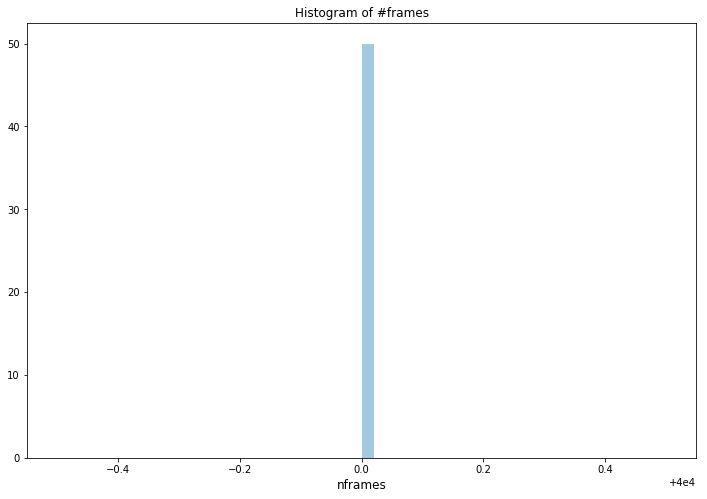

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(samples.nframes.values, bins=50, kde=False)
plt.xlabel('nframes', fontsize=12)
plt.title("Histogram of #frames")
plt.show()

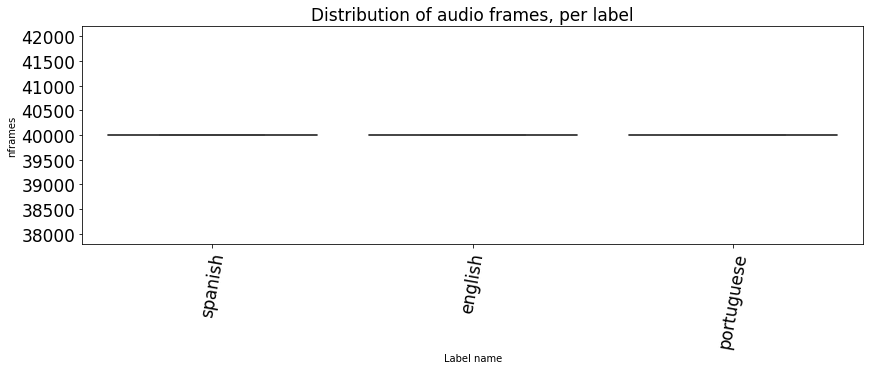

In [12]:
plt.figure(figsize=(14,4))
boxplot = sns.boxplot(x="label", y="nframes", data=samples)
boxplot.set(xlabel='', ylabel='')
plt.title('Distribution of audio frames, per label', fontsize=17)
plt.xticks(rotation=80, fontsize=17)
plt.yticks(fontsize=17)
plt.xlabel('Label name')
plt.ylabel('nframes')
plt.show()

In [13]:
temp = data.sort_values(by='label')
temp.head()

file_path    label  \
0   test/en\8609-283227-0031.__trim_0_5.1__remix_\...  english   
72  test/en\289-121665-0032.__trim_0_5.1__remix_\2...  english   
71  test/en\6415-116629-0035.__trim_0_5.1__remix_\...  english   
70  test/en\201-127786-0024.__trim_0_5.1__remix_\2...  english   
69  test/en\4051-10927-0025.__trim_0_5.1__remix_\4...  english   

                   file_name speed_changing pitch_changing noise_add low_pass  \
0   8609-283227-0031.__trim_           None           None      None     None   
72  289-121665-0032.__trim_0           None           None      None     None   
71  6415-116629-0035.__trim_           None           None      None     None   
70  201-127786-0024.__trim_0           None           None      None     None   
69  4051-10927-0025.__trim_0           None           None      None     None   

    augmented_data  
0            False  
72           False  
71           False  
70           False  
69           False

In [14]:
def get_index_label(label):
    for i, ins in enumerate(temp['label']):
        if ins == label:
            return i
get_index_label('english')

0

Total number of labels in training data :  3
Labels are :  ['english' 'portuguese' 'spanish']


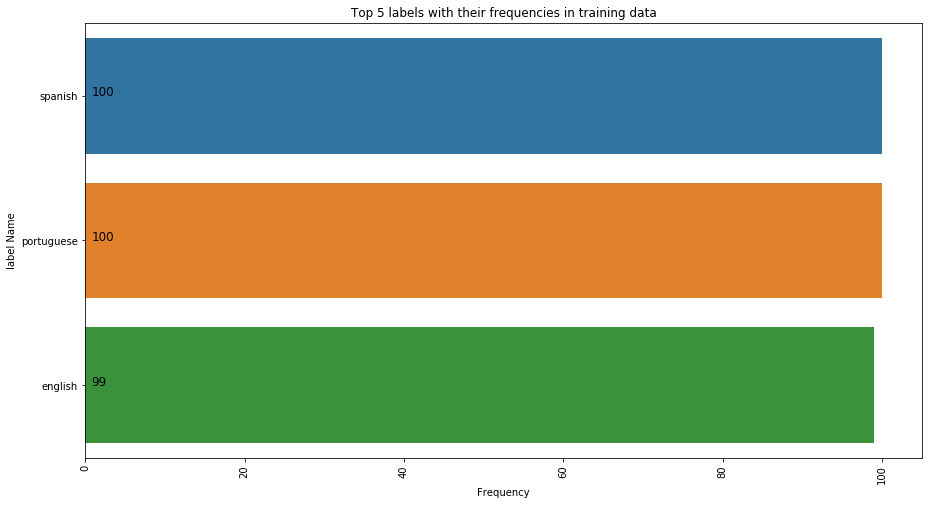

In [15]:
print("Total number of labels in training data : ",len(data['label'].value_counts()))
print("Labels are : ", data['label'].unique())
plt.figure(figsize=(15,8))
audio_type = data['label'].value_counts().head(5)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('label Name')
plt.title("Top 5 labels with their frequencies in training data")
plt.show()

In [16]:
data['gender'] = data['file_name'].apply(lambda n: n.split('_')[1])

## Instâncias por idioma

In [17]:
temp = data['label'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by language')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por quantidade de frames (amostras)

In [18]:
temp = samples['nframes'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por sample rate (amostras)

In [19]:
temp = samples['sample_rate'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Frames')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por duração total (amostras)

In [20]:
def duration(nframes, sample_rate):
    return sample_rate / nframes

In [21]:
samples['duration'] = pandas.DataFrame([duration(sr, b) for sr, b
                                        in zip(samples['sample_rate'], 
                                               samples['nframes'])])
temp = samples['duration'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by duration')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por _data augmentation_

In [22]:
temp = data['augmented_data'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Instances by Data Augmentation')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

## Instâncias por idioma e _data augmentation_

count
label      augmented_data       
english    False              99
portuguese False             100
spanish    False             100

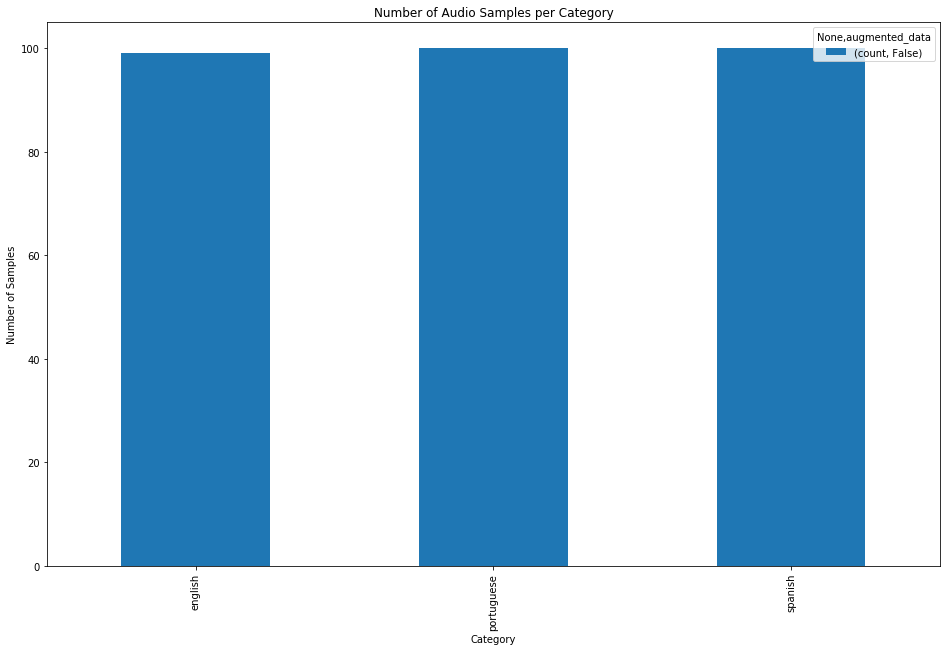

In [23]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['augmented_data']), 
                        columns=['count', 'label', 'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group

count  speed_changing  pitch_changing  noise_add  \
label      augmented_data                                                     
english    False              99               0               0          0   
portuguese False             100               0               0          0   
spanish    False             100               0               0          0   

                           low_pass  
label      augmented_data            
english    False                  0  
portuguese False                  0  
spanish    False                  0

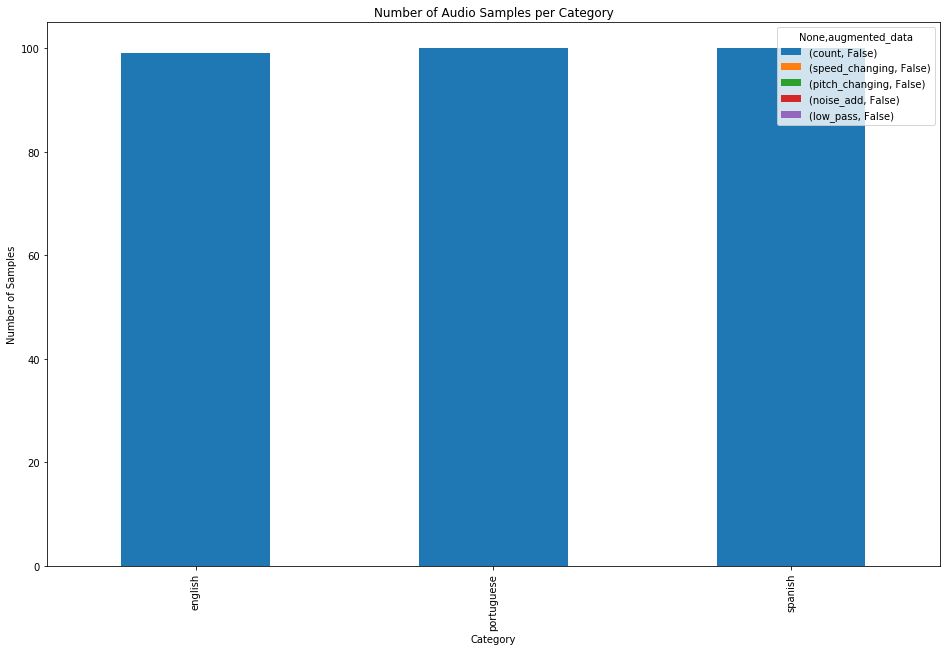

In [24]:
temp = pandas.DataFrame(zip(data['file_name'], data['label'], data['speed_changing'],
                            data['pitch_changing'], data['noise_add'], data['low_pass'], data['augmented_data']), 
                        columns=['count', 'label', 'speed_changing', 'pitch_changing', 'noise_add', 'low_pass',
                                'augmented_data'])
category_group = temp.groupby(['label', 'augmented_data']).count()
#category_group = category_group[category_group.speed_changing != 0]
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");
category_group.head()

## Waveform 

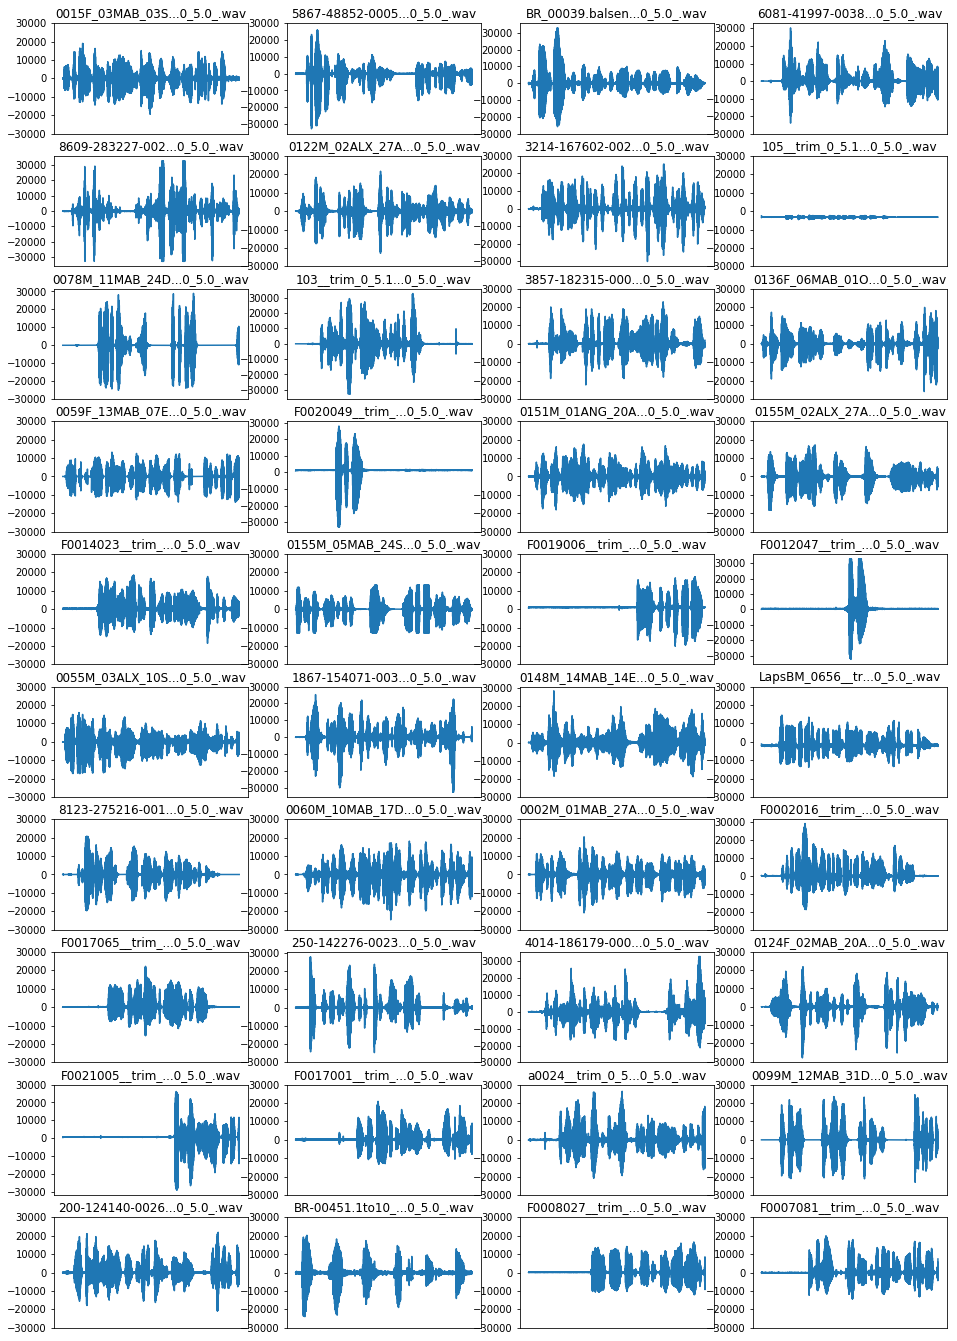

In [25]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    ax[i//4, i%4].plot(samples['time_series'][idx])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
    ax[i//4, i%4].get_yaxis().set_ticks([-30000, -20000, -10000, 0, 10000, 20000, 30000])
fig.savefig("AudioWaveform-{}-{}".format(DATASET, GROUP), dpi=900) 

## Spectrogram

In [26]:
sr, b = wavfile.read(data['file_path'][0])

In [27]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

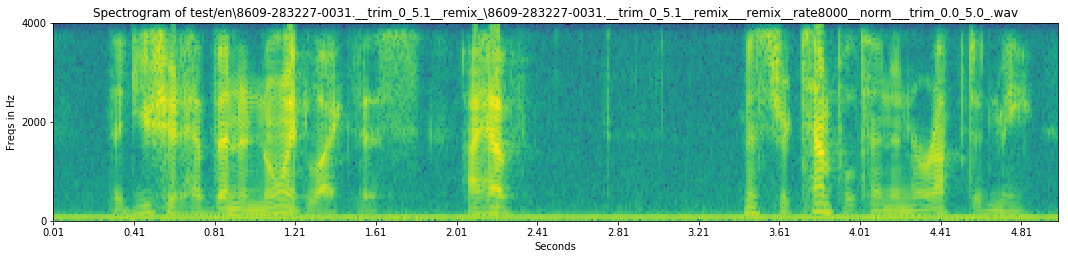

In [28]:
freqs, times, spectrogram = log_specgram(b, sr)

fig = plt.figure(figsize=(18, 8))
ax2 = fig.add_subplot(211)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::40])
ax2.set_xticks(times[::40])
ax2.set_title('Spectrogram of ' + data['file_path'][0])
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [29]:
print("Size of training data", data.shape)

Size of training data (299, 9)


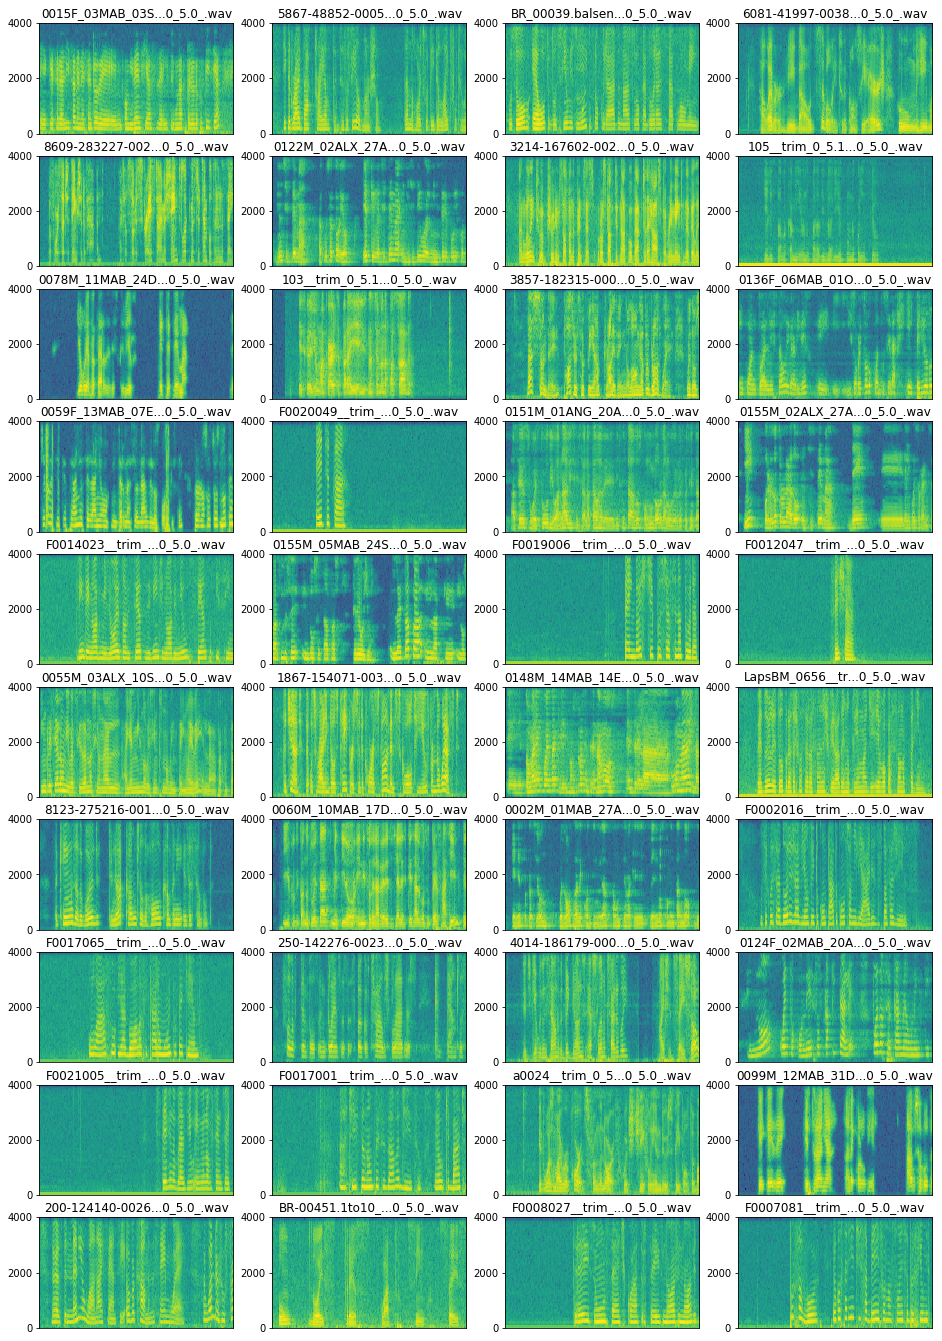

In [30]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = log_specgram(samples['time_series'][idx], sr)
    ax[i//4, i%4].imshow(spectrogram.T, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::40])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioSpectrograms-{}-{}".format(DATASET, GROUP), dpi=900) 

## MFCC

In [31]:
def mfcc_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc

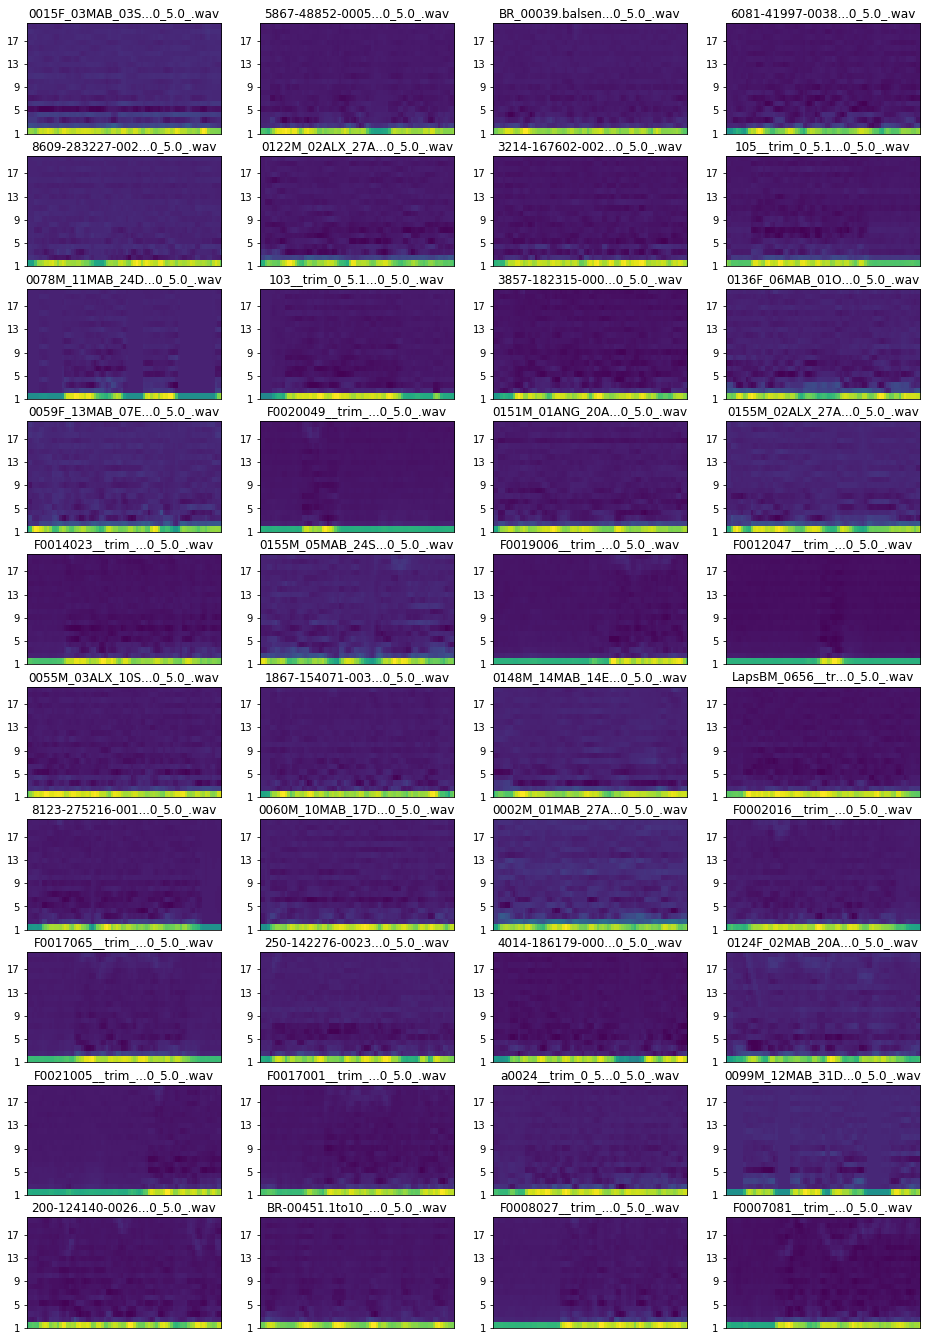

In [32]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_specgram(samples['time_series'][idx], sr,
                                              samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMFCCs-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta

In [33]:
def mfcc_delta_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

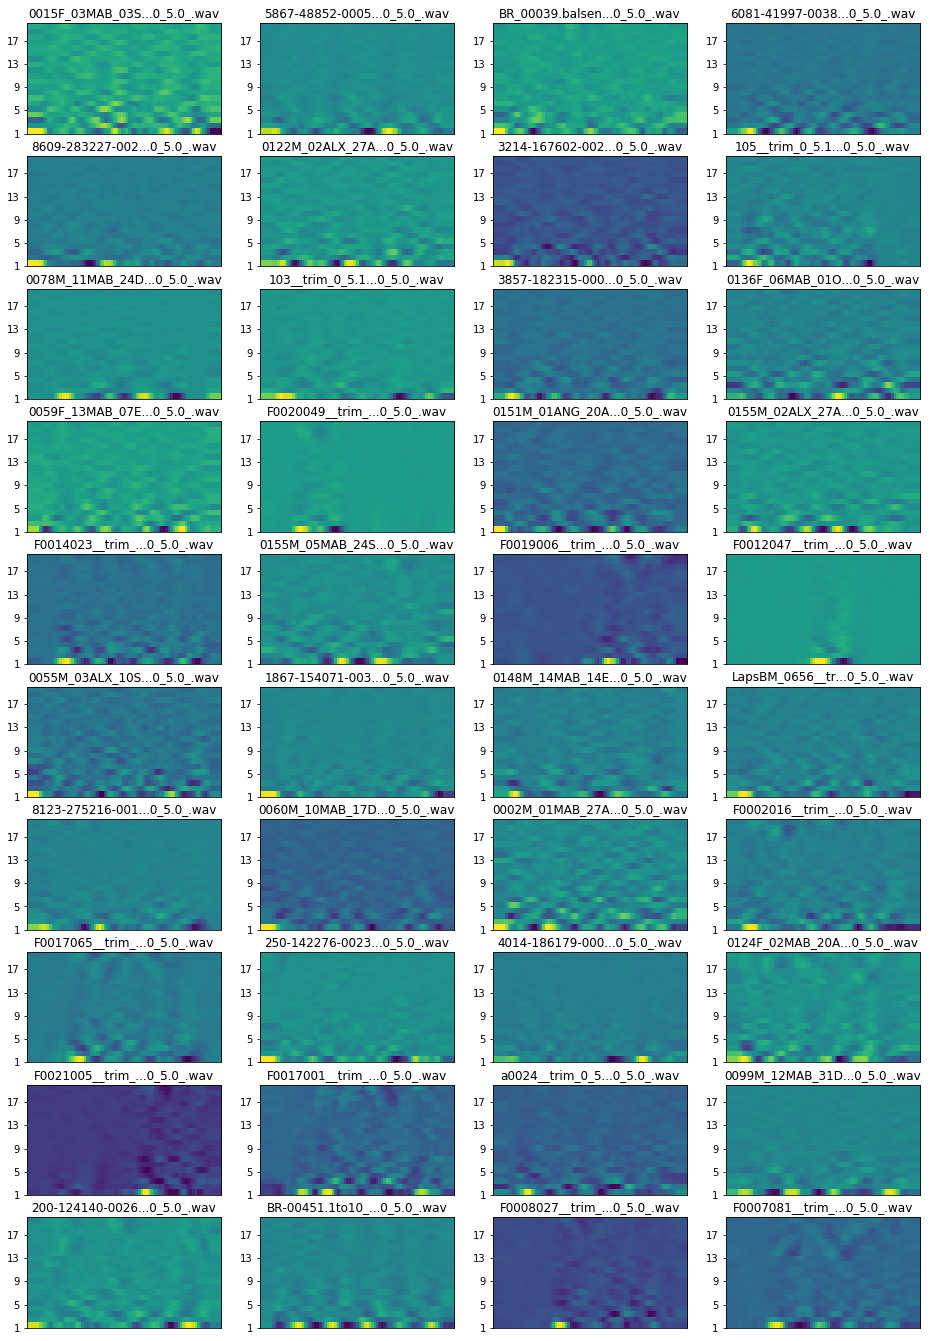

In [34]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_delta_specgram(samples['time_series'][idx], sr,
                                                    samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

### Delta Deltas

In [35]:
def mfcc_dd_specgram(audio, sample_rate, nframes, n_mfcc=13):
    mfcc = librosa.feature.mfcc(np.asarray(audio, dtype='Float64'), 
                                sample_rate, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc, order=2)
    times = np.linspace(0, nframes/sample_rate, mfcc.shape[0])
    freqs = np.linspace(1, n_mfcc, n_mfcc)
    return freqs, times, mfcc_delta

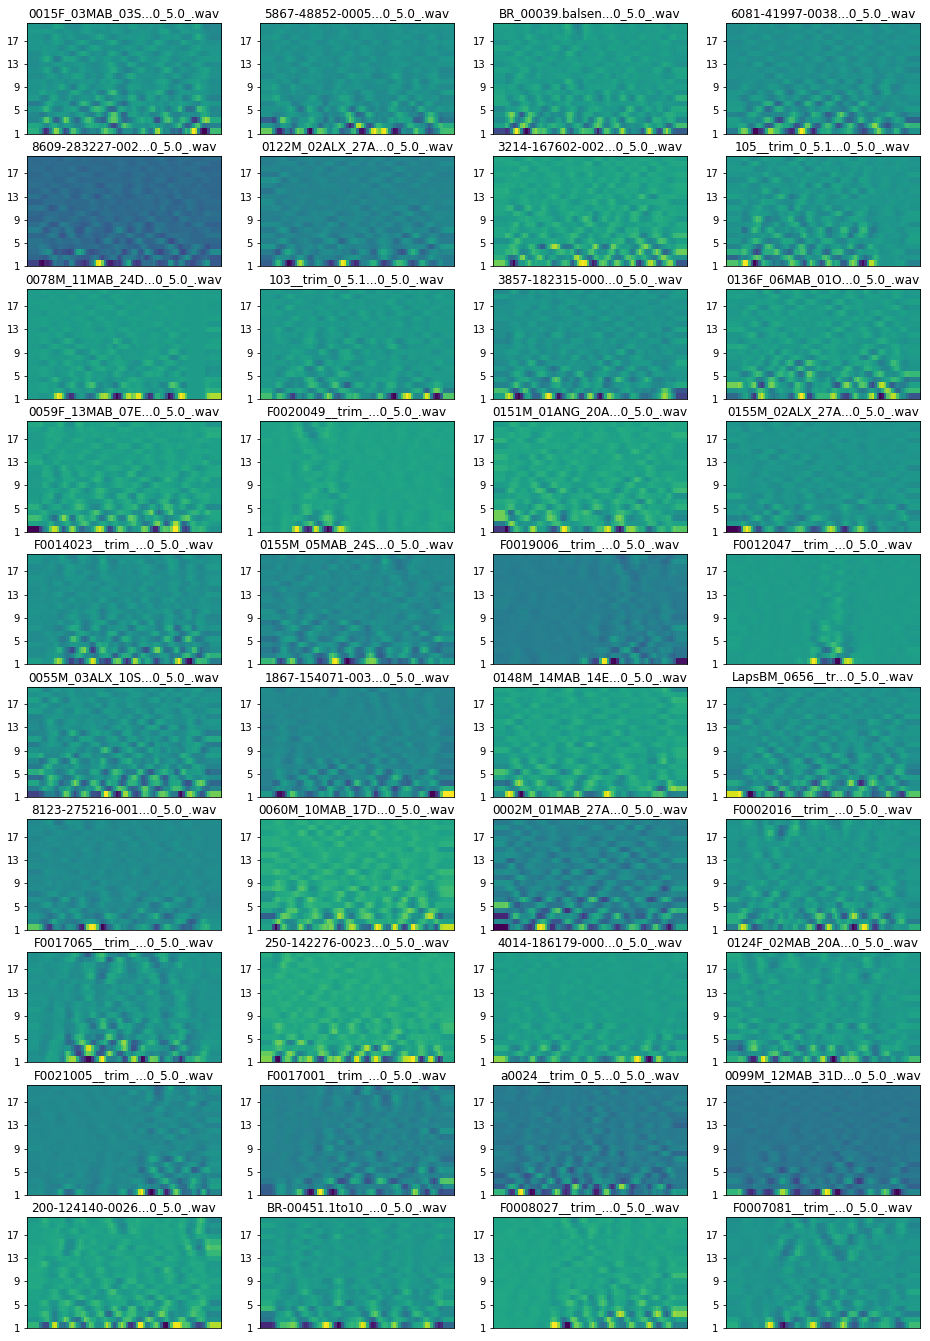

In [36]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mfcc_dd_specgram(samples['time_series'][idx], sr,
                                                 samples['nframes'][idx], n_mfcc=20)
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::4])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioDeltaDeltas-{}-{}".format(DATASET, GROUP), dpi=900)  

## Mel Spectrogram

In [37]:
def mel_specgram(audio, sample_rate, nframes):
    spec = librosa.feature.melspectrogram(np.asarray(audio, dtype='Float64'), 
                                          sample_rate)
    times = np.linspace(0, nframes/sample_rate, spec.shape[0])
    freqs = np.linspace(1, spec.shape[1], spec.shape[1])
    return freqs, times, spec

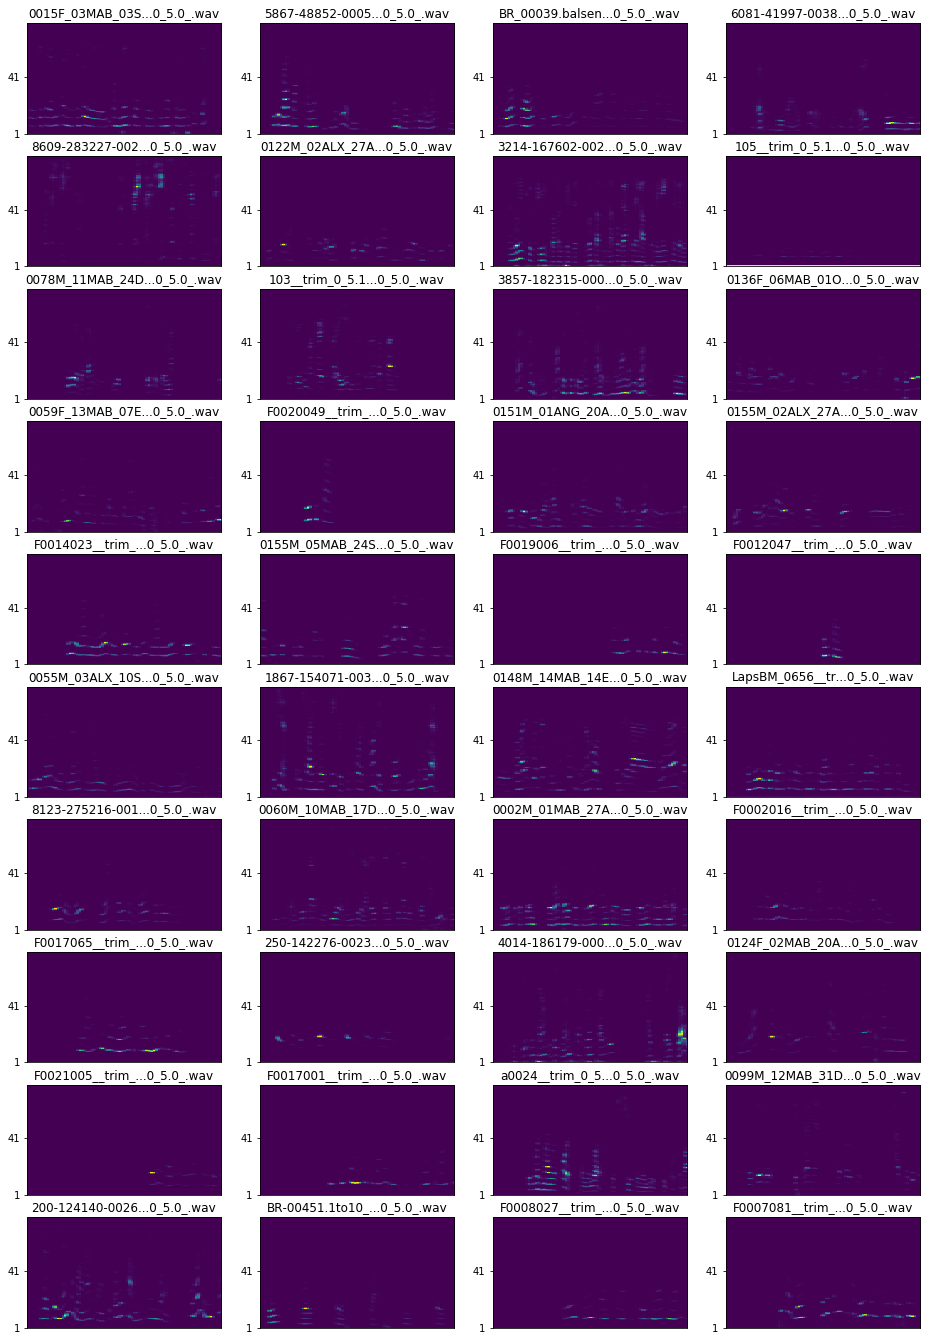

In [38]:
fig, ax = plt.subplots(10, 4, figsize = (16, 24))
for i, idx in enumerate(samples.head(40).index):
    freqs, times, spectrogram = mel_specgram(samples['time_series'][idx], sr,
                                             samples['nframes'][idx])
    ax[i//4, i%4].imshow(spectrogram, aspect='auto', origin='lower', 
                         extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax[i//4, i%4].set_yticks(freqs[::40])
    ax[i//4, i%4].set_xticks(times[::2])
    ax[i//4, i%4].set_title(samples['file_name'][idx][:15] + '...' + samples['file_name'][idx][-10:])
    ax[i//4, i%4].get_xaxis().set_ticks([])
fig.savefig("AudioMelSpecs-{}-{}".format(DATASET, GROUP), dpi=900)  